In [2]:
#Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [3]:
#Set Parameters here
epochs = 200000
batch_size = 1000
train_points = 1000 # 60k total training examples, 10k test examples
test_points = 1000
lr = 0.001
weight_decay = 0.01
initialization_scale = 8.0
#Optmization steps should be train_points/batchsize * epochs 
print(train_points/batch_size * epochs)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


200000.0


In [4]:
#Network Structure
class WineClassification(nn.Module):
    def __init__(self):
        super(WineClassification, self).__init__()
        width = 200
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(11, width).to(device)
        self.fc2 = nn.Linear(width, width).to(device)
        self.fc3 = nn.Linear(width, 10).to(device)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = WineClassification().to(device)


with torch.no_grad(): 
    for p in model.parameters(): 
        p.data = initialization_scale * p.data

In [ ]:
data = pd.read_csv('wine+quality/winequality-white.csv', delimiter=';') 
X = data.drop('quality', axis=1).values
y = data['quality'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

# Standardize the data 
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors 
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create TensorDataset and DataLoader 
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor) 
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor) 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=True) 
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(len(train_loader)) 
print(len(test_loader))

1
5


Epoch [10000/200000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4792, Weight Norm: 157.8603:   5%|▍         | 9999/200000 [11:50<3:14:33, 16.28it/s]

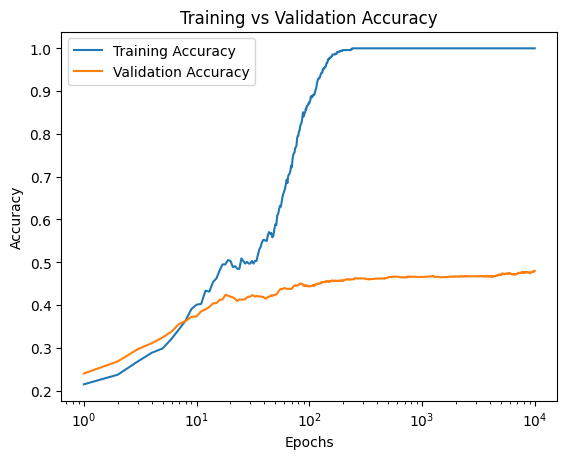

Epoch [20000/200000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4752, Weight Norm: 146.5066:  10%|▉         | 19999/200000 [22:59<3:07:49, 15.97it/s] 

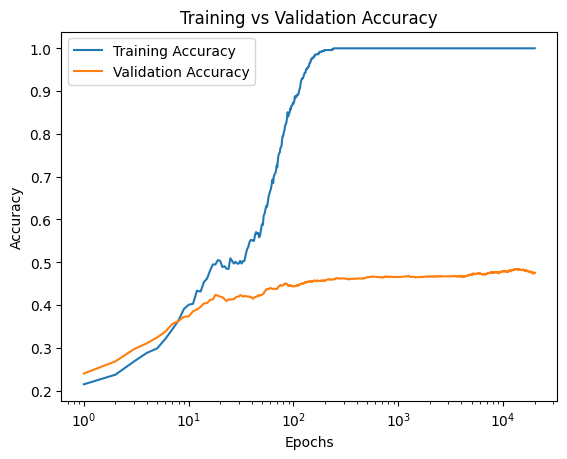

Epoch [30000/200000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4824, Weight Norm: 158.3208:  15%|█▍        | 29999/200000 [35:20<4:09:24, 11.36it/s] 

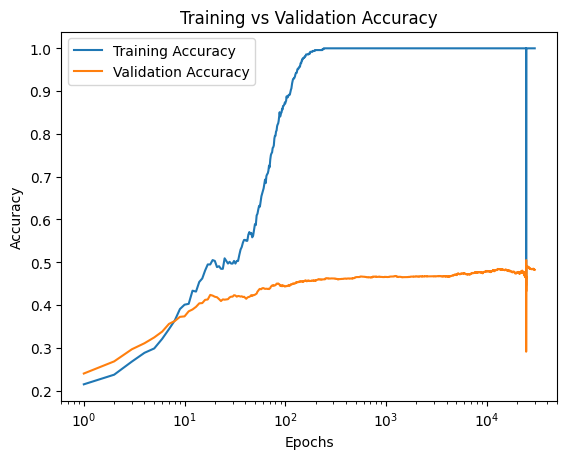

Epoch [40000/200000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4820, Weight Norm: 143.7744:  20%|█▉        | 39999/200000 [48:17<3:52:18, 11.48it/s]

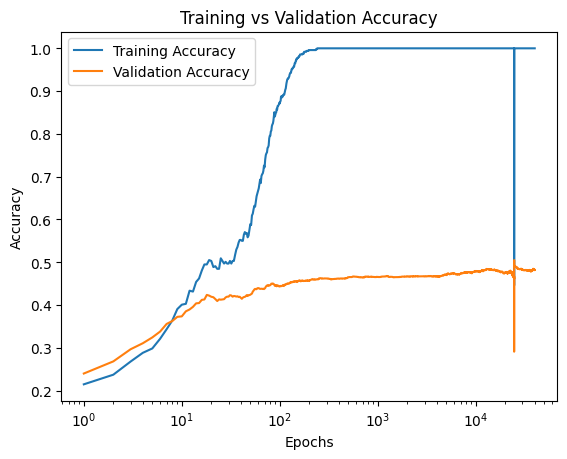

Epoch [50000/200000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4731, Weight Norm: 189.3652:  25%|██▍       | 49999/200000 [1:00:46<2:52:19, 14.51it/s]

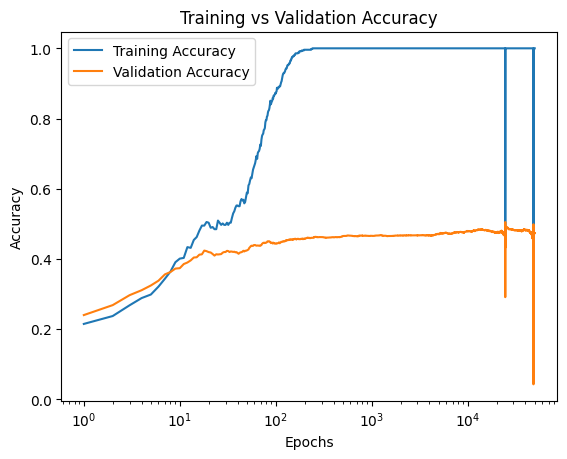

Epoch [60000/200000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4749, Weight Norm: 171.4316:  30%|██▉       | 59999/200000 [1:12:57<2:26:01, 15.98it/s]

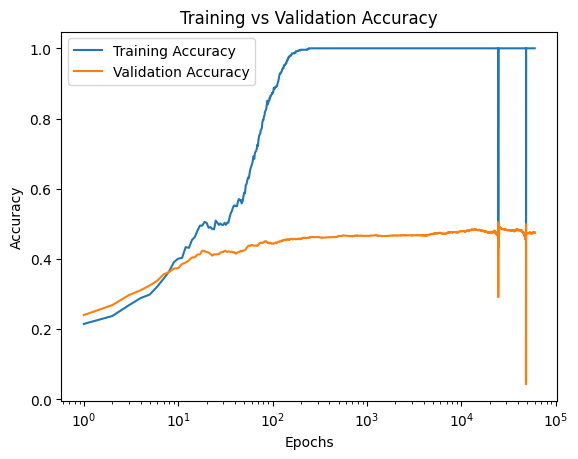

Epoch [70000/200000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4722, Weight Norm: 165.8710:  35%|███▍      | 69999/200000 [1:24:53<2:21:28, 15.31it/s]

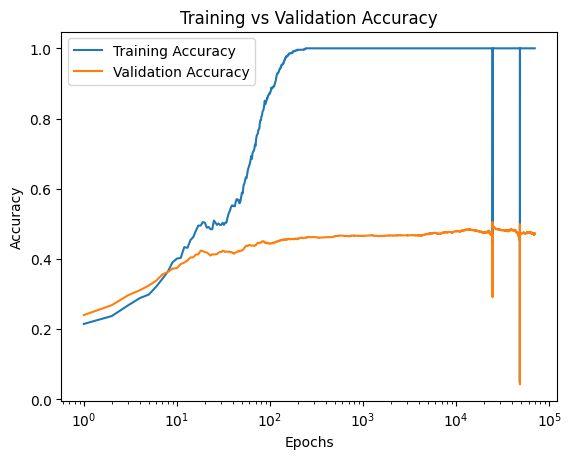

Epoch [80000/200000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4777, Weight Norm: 209.5972:  40%|███▉      | 79998/200000 [1:36:49<2:27:13, 13.59it/s]  

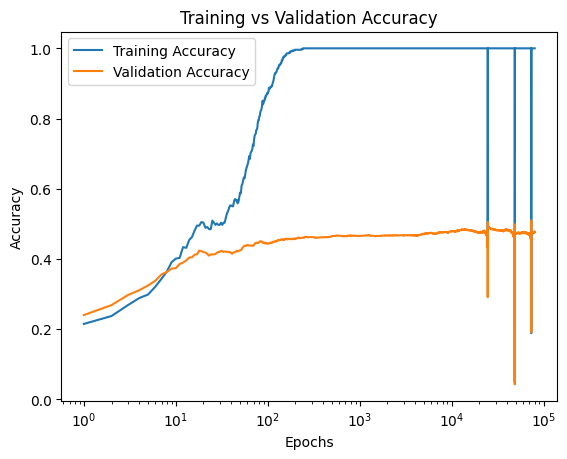

Epoch [90000/200000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4738, Weight Norm: 190.5463:  45%|████▍     | 89999/200000 [1:48:32<2:16:28, 13.43it/s]

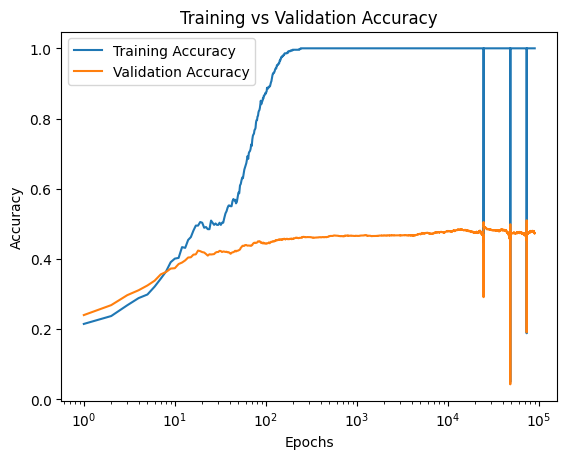

Epoch [100000/200000], Loss: 0.0002, Train Accuracy: 1.0000, Val Accuracy: 0.4713, Weight Norm: 255.3478:  50%|████▉     | 99999/200000 [2:00:31<1:49:19, 15.24it/s] 

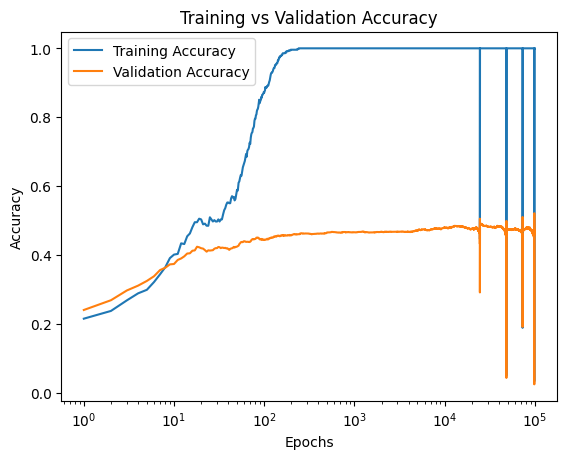

Epoch [110000/200000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4731, Weight Norm: 231.2455:  55%|█████▍    | 109998/200000 [2:11:51<1:36:06, 15.61it/s]

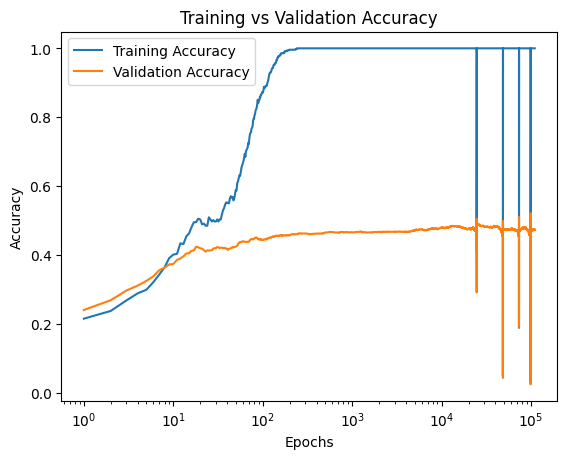

Epoch [120000/200000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4711, Weight Norm: 213.5654:  60%|█████▉    | 119998/200000 [2:22:46<1:19:14, 16.83it/s]

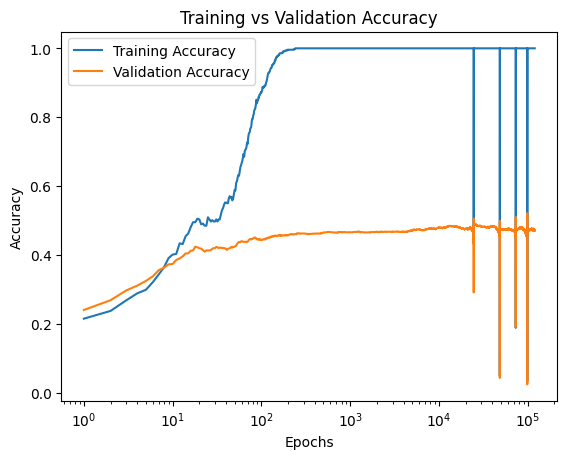

Epoch [130000/200000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4727, Weight Norm: 260.5472:  65%|██████▍   | 129998/200000 [2:33:50<1:15:59, 15.35it/s]  

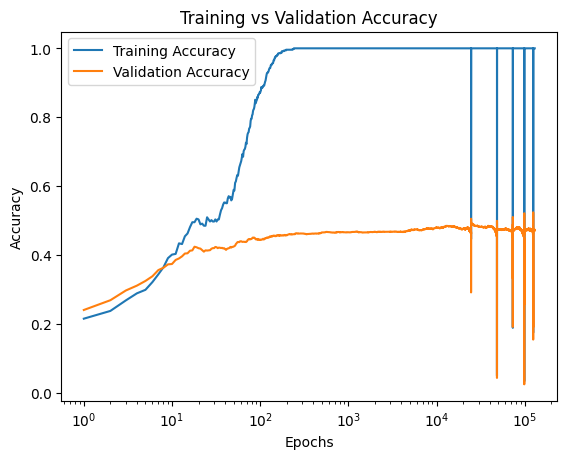

Epoch [140000/200000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4758, Weight Norm: 236.7658:  70%|██████▉   | 139998/200000 [2:44:59<1:07:37, 14.79it/s]

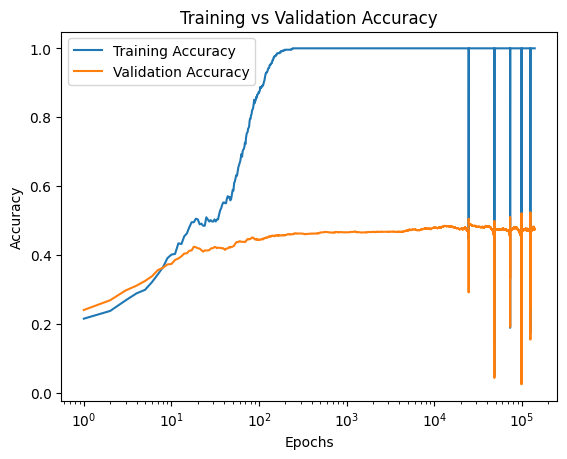

Epoch [150000/200000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4702, Weight Norm: 277.3361:  75%|███████▍  | 149999/200000 [2:58:01<1:02:48, 13.27it/s]

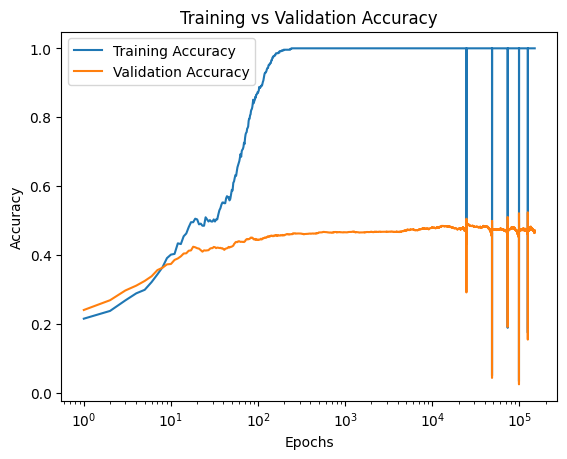

Epoch [160000/200000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4695, Weight Norm: 256.7295:  80%|███████▉  | 159999/200000 [3:11:36<52:43, 12.64it/s]    

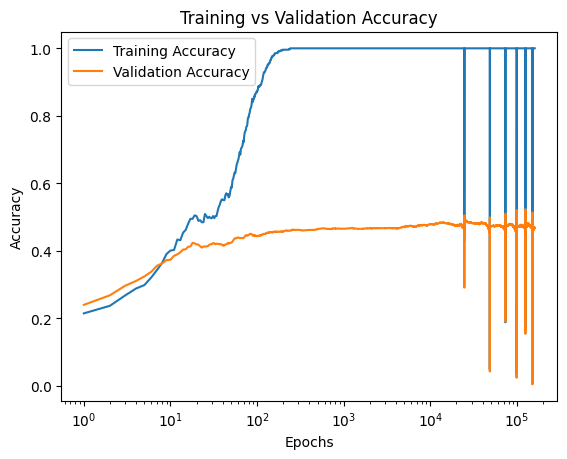

Epoch [170000/200000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4747, Weight Norm: 234.4633:  85%|████████▍ | 169999/200000 [3:24:46<37:05, 13.48it/s]  

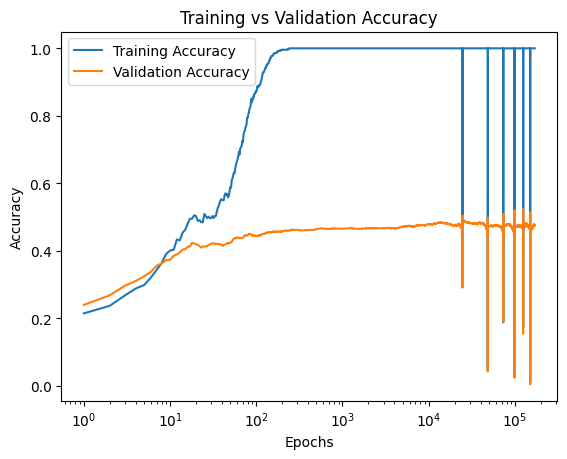

Epoch [180000/200000], Loss: 0.0002, Train Accuracy: 1.0000, Val Accuracy: 0.4731, Weight Norm: 257.6151:  90%|████████▉ | 179998/200000 [3:36:54<22:00, 15.15it/s]  

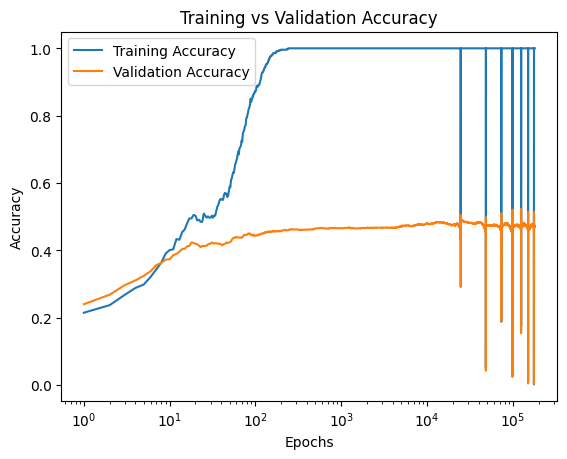

Epoch [190000/200000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4747, Weight Norm: 234.1546:  95%|█████████▍| 189998/200000 [3:50:00<17:00,  9.80it/s]

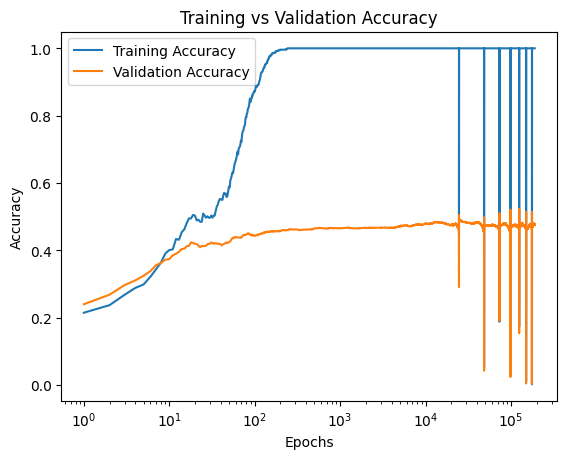

Epoch [200000/200000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4770, Weight Norm: 230.6631: 100%|█████████▉| 199998/200000 [4:02:52<00:00, 13.97it/s]

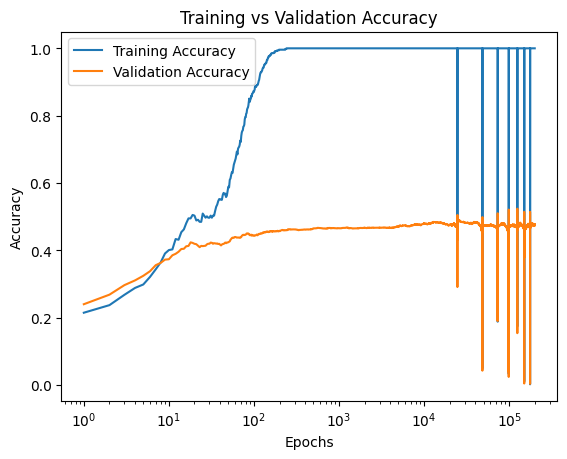

Epoch [200000/200000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4770, Weight Norm: 230.6631: 100%|██████████| 200000/200000 [4:02:53<00:00, 13.72it/s]


In [7]:
#Training

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

train_acc = []
val_acc = []
train_loss = []
weight_normlist = []

#Loop
bar = tqdm(range(epochs))
for epoch in bar:
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        labels_one_hot = F.one_hot((labels).long(), 10).float()
        loss = criterion(outputs, labels_one_hot)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Calculate Train Accuracy
    _, predicted = torch.max(outputs.data, 1)
    correct_train += (predicted == labels).sum().item()
    total_train += labels.size(0)
    train_accuracy = correct_train / total_train
    train_acc.append(train_accuracy)
    
    # Store loss
    train_loss.append(loss.item())
    
    # Calculate Validation Accuracy
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for x, labels in test_loader:
            y = model(x)
            _, predicted = torch.max(y, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    val_accuracy = correct / total
    val_acc.append(val_accuracy)

    # Calculate Weight Norm
    weight_norm = sum(p.norm().item() for p in model.parameters())
    weight_normlist.append(weight_norm)
    
    # Print progress
    bar.set_description(f'Epoch [{epoch+1}/{epochs}], Loss: {loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Weight Norm: {weight_norm:.4f}')
    
    # Plot graph every 50,000 epochs
    if (epoch + 1) % 10000 == 0:
        import matplotlib.pyplot as plt
        plt.xscale("log")
        plt.plot(range(1, epoch + 2), train_acc, label='Training Accuracy')
        plt.plot(range(1, epoch + 2), val_acc, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training vs Validation Accuracy')
        plt.legend()
        plt.show()


In [8]:
#Evaluate
model.eval()
total = 0
correct = 0
one_hots = torch.eye(10, 10)
with torch.no_grad():
        for x, labels in test_loader:
            y = model(x)
            _, predicted = torch.max(y,1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)


print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 47.70%


In [9]:
import matplotlib.pyplot as plt

# Function to display images and predictions
def display_predictions(model, testloader, num_images=5):
    model.eval()
    images, labels = next(iter(testloader))
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i].numpy().squeeze(), cmap='gray')
        ax.set_title(f'Pred: {predicted[i].item()}')
        ax.axis('off')
    plt.show()

# Evaluate the model
model.eval()
correct = 0
total = 0
one_hots = torch.eye(10, 10)

with torch.no_grad():
    for x, labels in test_loader:
        y = model(x)
        _, predicted = torch.max(y, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f'Accuracy: {100 * accuracy:.2f}%')

# Display example predictions
#display_predictions(model, test_loader, num_images=5)


Accuracy: 47.70%


In [10]:
"""#Training

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

train_acc = []
val_acc = []
train_loss = []
weight_normlist = []

#Loop
bar = tqdm(range(epochs))
for epoch in bar:
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        labels_one_hot = F.one_hot(labels, 10).float()
        loss = criterion(outputs, labels_one_hot)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    #Calculate Train Accuracy
    _, predicted = torch.max(outputs.data, 1)
    correct_train += (predicted == labels).sum().item()
    total_train += labels.size(0)
    train_accuracy = correct_train / total_train
    train_acc.append(train_accuracy)
    #Store loss
    train_loss.append(loss)
    #Calculate Validation Accuracy
    model.eval()
    total = 0
    correct = 0
    one_hots = torch.eye(10, 10)
    with torch.no_grad():
            for x, labels in test_loader:
                y = model(x)
                _, predicted = torch.max(y,1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
    val_accuracy = correct / total
    val_acc.append(val_accuracy)

    #Calculate Weight Norm
    weight_norm = sum(p.norm().item() for p in model.parameters())
    weight_normlist.append(weight_norm)
    #print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')
    bar.set_description(f'Epoch [{epoch+1}/{epochs}], Loss: {loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Weight Norm: {weight_norm:.4f}')"""

"#Training\n\ncriterion = nn.MSELoss()\noptimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)\n\ntrain_acc = []\nval_acc = []\ntrain_loss = []\nweight_normlist = []\n\n#Loop\nbar = tqdm(range(epochs))\nfor epoch in bar:\n    model.train()\n    running_loss = 0.0\n    correct_train = 0\n    total_train = 0\n    \n    for images, labels in train_loader:\n        optimizer.zero_grad()\n        outputs = model(images)\n        labels_one_hot = F.one_hot(labels, 10).float()\n        loss = criterion(outputs, labels_one_hot)\n        loss.backward()\n        optimizer.step()\n        running_loss += loss.item()\n\n    #Calculate Train Accuracy\n    _, predicted = torch.max(outputs.data, 1)\n    correct_train += (predicted == labels).sum().item()\n    total_train += labels.size(0)\n    train_accuracy = correct_train / total_train\n    train_acc.append(train_accuracy)\n    #Store loss\n    train_loss.append(loss)\n    #Calculate Validation Accuracy\n    model.eval()\n    tot